<a href="https://colab.research.google.com/github/salmaacoine/XRay-Pneumonia-Classification/blob/main/pneumonia_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
print("Montage de Google Drive...")
drive.mount('/content/drive')
print("Vérifiez que le GPU est activé dans le menu 'Environnement d'exécution'!")

Montage de Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vérifiez que le GPU est activé dans le menu 'Environnement d'exécution'!


In [ ]:
from google.colab import drive
import os
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/archive.zip'
destination_path = '/content/data/chest_xrays/'

print(f"Décompression de {zip_path} dans {destination_path}...")
!mkdir -p {destination_path}
!unzip -q {zip_path} -d {destination_path}
print("Décompression terminée.")
print("\nStructure des dossiers dans le répertoire de destination:")
print(os.listdir(destination_path))

Décompression de /content/drive/MyDrive/archive.zip dans /content/data/chest_xrays/...
Décompression terminée.

Structure des dossiers dans le répertoire de destination:
['chest_xray']


In [ ]:

chemin_interne = os.listdir(destination_path)[0]

dataset_path = os.path.join(destination_path, chemin_interne, 'train')


import os
dataset_path = '/content/data/chest_xrays/chest_xray/train'

print(f"\nContenu du dossier TRAIN ({dataset_path}):")
print(os.listdir(dataset_path))


Contenu du dossier TRAIN (/content/data/chest_xrays/chest_xray/train):
['PNEUMONIA', 'NORMAL']


In [ ]:
import numpy as np
import pandas
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

Nombre d'images NORMALES : 1341
Nombre d'images PNEUMONIA : 3875


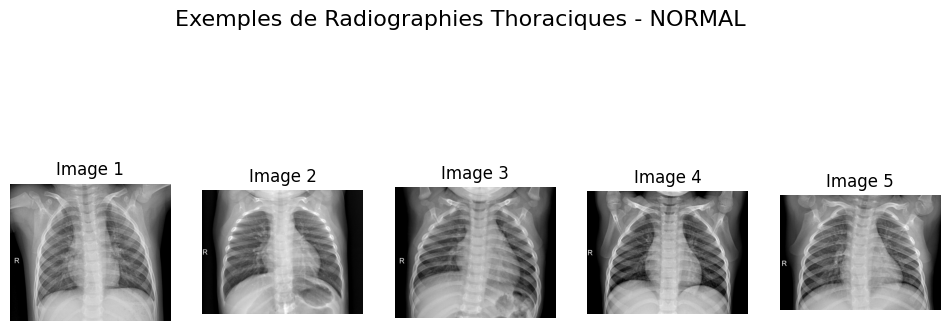

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
base_train_path = '/content/data/chest_xrays/chest_xray/train'
normal_path = os.path.join(base_train_path, 'NORMAL')
pneumonia_path = os.path.join(base_train_path, 'PNEUMONIA')
normal_images = os.listdir(normal_path)
pneumonic_images = os.listdir(pneumonia_path)

print(f"Nombre d'images NORMALES : {len(normal_images)}")
print(f"Nombre d'images PNEUMONIA : {len(pneumonic_images)}")
plt.figure(figsize=(12, 5))
plt.suptitle("Exemples de Radiographies Thoraciques - NORMAL", fontsize=16)

for i, img_path in enumerate(normal_images[:5]):
    img = cv2.imread(os.path.join(normal_path, img_path), cv2.IMREAD_GRAYSCALE)

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.show()


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
base_train_path = '/content/data/chest_xrays/chest_xray/train'
normal_path = os.path.join(base_train_path, 'NORMAL')
pneumonia_path = os.path.join(base_train_path, 'PNEUMONIA')
normal_images = os.listdir(normal_path)
pneumonic_images = os.listdir(pneumonia_path)

print(f"Nombre d'images NORMALES : {len(normal_images)}")
print(f"Nombre d'images PNEUMONIA : {len(pneumonic_images)}")

Nombre d'images NORMALES : 1341
Nombre d'images PNEUMONIA : 3875


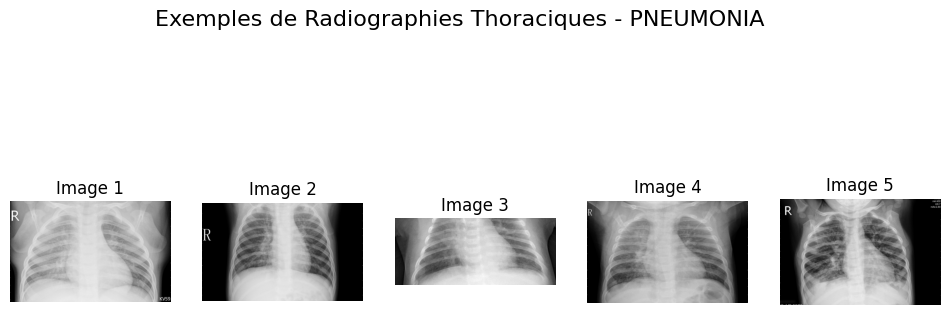

In [ ]:
plt.figure(figsize=(12, 5))
plt.suptitle("Exemples de Radiographies Thoraciques - PNEUMONIA", fontsize=16)

for i, img_path in enumerate(pneumonic_images[:5]):
    img = cv2.imread(os.path.join(pneumonia_path, img_path), cv2.IMREAD_GRAYSCALE)

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2

base_dir = '/content/data/chest_xrays/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' if NUM_CLASSES > 2 else 'binary'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' if NUM_CLASSES > 2 else 'binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

if train_generator.class_mode == 'binary':
    output_classes = 1
    loss_function = 'binary_crossentropy'
else:
    output_classes = train_generator.num_classes
    loss_function = 'categorical_crossentropy'

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
predictions = Dense(output_classes,
                    activation='sigmoid' if output_classes == 1 else 'softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=loss_function,
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.7517 - loss: 0.4841 - val_accuracy: 0.5625 - val_loss: 0.7518
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 635ms/step - accuracy: 0.7567 - loss: 0.4765 - val_accuracy: 0.5625 - val_loss: 0.7893
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.7689 - loss: 0.4521 - val_accuracy: 0.5625 - val_loss: 0.8087
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accuracy: 0.7628 - loss: 0.4504 - val_accuracy: 0.5625 - val_loss: 0.8297
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 626ms/step - accuracy: 0.7875 - loss: 0.4244 - val_accuracy: 0.5625 - val_loss: 0.7426
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 632ms/step - accuracy: 0.7926 - loss: 0.4196 - val_accuracy: 0.5625 - val_loss: 0.7229
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 635ms/step - accuracy: 0.8004 - loss: 0.4096 - val_accuracy: 0.5625 - val_loss: 0.7475
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.8059 -

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

base_model.trainable = True

freeze_until_layer = 140

for layer in base_model.layers[:freeze_until_layer]:
    layer.trainable = False

print(f"Nombre de couches entraînables après affinage : {len([layer for layer in model.layers if layer.trainable])}")

Nombre de couches entraînables après affinage : 3


In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss=loss_function,
    metrics=['accuracy']
)

print("Lancement de la phase d'affinage (Fine-Tuning)...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Lancement de la phase d'affinage (Fine-Tuning)...


In [ ]:

test_dir = os.path.join(base_dir, 'test')


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' if NUM_CLASSES > 2 else 'binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np

print("Obtention des prédictions sur le jeu de test...")
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)

true_labels = test_generator.classes[:len(Y_pred)]

if test_generator.class_mode == 'binary':
    predicted_labels = (Y_pred > 0.5).astype(int).flatten()

else:
    predicted_labels = np.argmax(Y_pred, axis=1)

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
target_names = list(test_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=target_names))

print("\n" + "="*50)
print("MATRICE DE CONFUSION")
print("="*50)
print(confusion_matrix(true_labels, predicted_labels))

if test_generator.class_mode == 'binary':
    auc_score = roc_auc_score(true_labels, Y_pred)
    print(f"\nAUC (Area Under the Curve) : {auc_score:.4f}")

Obtention des prédictions sur le jeu de test...
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       0.81      0.37      0.51       234
   PNEUMONIA       0.71      0.95      0.81       390

    accuracy                           0.73       624
   macro avg       0.76      0.66      0.66       624
weighted avg       0.75      0.73      0.70       624


MATRICE DE CONFUSION
[[ 86 148]
 [ 20 370]]

AUC (Area Under the Curve) : 0.8677


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy'])

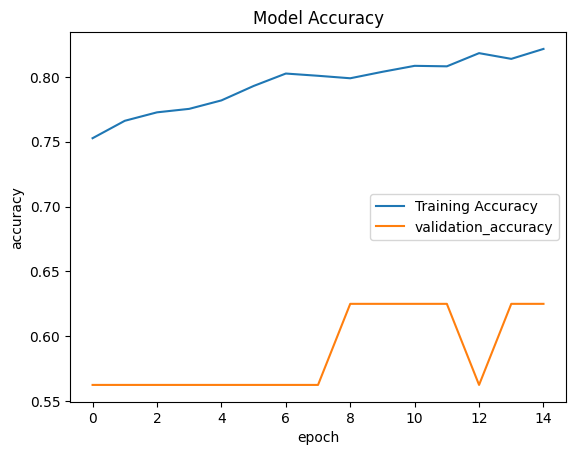

In [ ]:

plt.plot(history.history['accuracy'], label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation_accuracy')
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('best_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
!pip freeze > requirements.txt